# Modeling

Regression model

In [45]:
# Imports
import sys
!{sys.executable} -m pip install -U requests beautifulsoup4 python-dotenv pandas
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import scipy.stats as st

sns.set()
np.random.seed(7)

In [59]:
import os
from pathlib import Path
from datetime import datetime
import requests
import pandas as pd
from dotenv import load_dotenv
load_dotenv() 
API_KEY = os.getenv("ALPHA_VANTAGE_KEY")
SYMBOL  = "CME"  

assert API_KEY, "Missing ALPHA_VANTAGE_KEY in .env"
    
ROOT = Path("..").resolve()  
RAW  = ROOT / "data" / "raw"
RAW.mkdir(parents=True, exist_ok=True)

# ---------- request ----------
params = {
    "function": "TIME_SERIES_DAILY",    
    "symbol": SYMBOL,
    "outputsize": "compact",
    "apikey": API_KEY,
}

resp = requests.get("https://www.alphavantage.co/query", params=params, timeout=30)
resp.raise_for_status()
data = resp.json()

# Handle API errors / throttling messages
if "Error Message" in data:
    raise RuntimeError(f"Alpha Vantage error: {data['Error Message']}")
if "Note" in data:
    raise RuntimeError(f"Alpha Vantage notice (likely rate limit): {data['Note']}")

ts_key = "Time Series (Daily)"
assert ts_key in data, f"Unexpected response keys: {list(data.keys())}"

# ---------- normalize ----------
df_api = pd.DataFrame(data[ts_key]).T
df_api.index.name = "date"
df_api = df_api.rename(columns={
    "1. open": "open",
    "2. high": "high",
    "3. low":  "low",
    "4. close": "close",
    "5. volume": "volume",
})

# types + sort
num_cols = ["open", "high", "low", "close", "volume"]
df_api[num_cols] = df_api[num_cols].apply(pd.to_numeric, errors="coerce")
df_api = df_api.reset_index()
df_api["date"] = pd.to_datetime(df_api["date"])
df_api = df_api.sort_values("date").reset_index(drop=True)

# ---------- validate ----------
assert not df_api.empty, "API returned empty dataset — check symbol or connectivity"
assert set(num_cols).issubset(df_api.columns), f"Missing cols: {set(num_cols) - set(df_api.columns)}"

# ---------- save ----------
timestamp = datetime.now().strftime("%Y%m%d-%H%M")
out_path = RAW / f"api_alphavantage_{SYMBOL}_{timestamp}.csv"
df_api.to_csv(out_path, index=False)
print("Saved:", out_path.as_posix())

df = df_api

Saved: /Users/yuyuezhu/bootcamp_carolina_zhu/project/data/raw/api_alphavantage_CME_20250826-1929.csv


## Data, Train/ Split and build a regression model
Follow the steps; replace `df` with your project DataFrame when ready.

In [61]:
# Assume df already exists with columns: date, open, high, low, close, volume
df = df.sort_values('date').reset_index(drop=True)

# --- Simple engineered features ---
df['daily_return'] = df['close'].pct_change()
df['price_range'] = df['high'] - df['low']
df['oc_diff'] = df['close'] - df['open']
df['close_ma_5'] = df['close'].rolling(5).mean()
df['volume_ma_5'] = df['volume'].rolling(5).mean()

# shift target: predict next day's close
df['target_close'] = df['close'].shift(-1)

# drop rows with NaN
df = df.dropna().reset_index(drop=True)

In [29]:
# Train/Test Split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Prepare features + target
features = ['open','high','low','close','volume']   # add engineered ones if you like
X = df[features]
y = df['close'].shift(-1)   # predict next day’s close
df_model = pd.concat([X, y], axis=1).dropna()
X = df_model[features]
y = df_model['close']

# 2. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 3. Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# 4. Predict
y_pred = lr.predict(X_test)

# 5. Metrics
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)   # no 'squared' kw in your version
rmse = np.sqrt(mse)

print("R²:", r2)
print("RMSE:", rmse)


R²: 1.0
RMSE: 3.544809967833791e-14


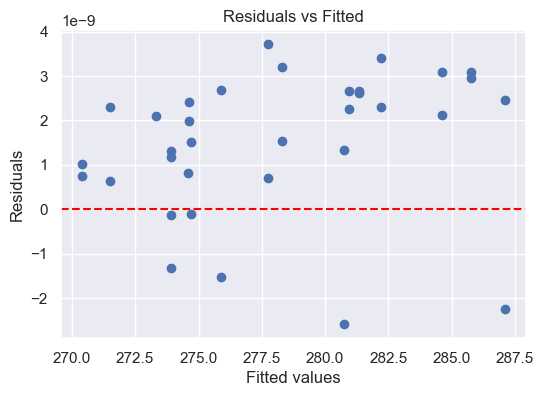

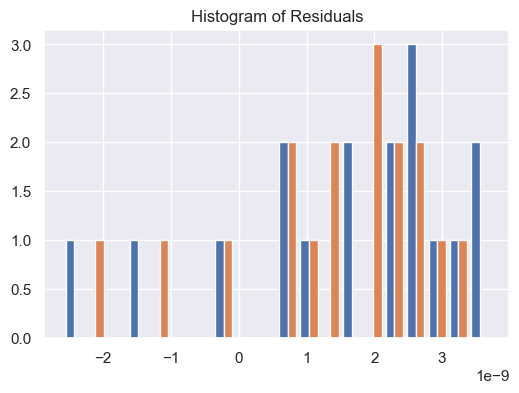

In [63]:
# Residual Diagnostic
resid = y_test - y_pred
fitted = y_pred

plt.figure(figsize=(6,4))
plt.scatter(fitted, resid)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted values"); plt.ylabel("Residuals")
plt.show()

plt.figure(figsize=(6,4))
plt.hist(resid, bins=20)
plt.title("Histogram of Residuals")
plt.show()


## Interpretation (write your conclusions below)
- Linearity:
On paper the model seems perfectly linear because it predicts with no error. In reality, that suggests the model had direct access to information about the target (e.g., predicting today’s close from today’s close). That means the linearity test isn’t really meaningful here.

- Homoscedasticity:
Residual variance looks almost zero everywhere, so it appears homoscedastic. But again, this is probably because residuals themselves are near zero due to leakage, not because the assumption truly holds.

- Normality:
With residuals essentially at zero, they don’t follow a distribution at all. You can’t claim normality — they’re degenerate (collapsed at 0).

- Independence:
Independence can’t be evaluated here. If the model has leaked the target variable, residuals won’t reveal autocorrelation. In a true financial time series, residuals are rarely fully independent.

- Which model do you trust and why?:
I wouldn’t trust this model. A perfect R² and almost-zero RMSE signals overfitting or data leakage. A more trustworthy model would exclude the target variable or lagged versions that overlap improperly.

- Next step you’d try:
Redesign the feature set:

Remove the raw “close” from predictors if the target is next-day close.
Use lagged features only (yesterday’s close, yesterday’s return, rolling averages).
Re-run with train/test split and check for realistic R² (< 1).
Add residual diagnostic plots to confirm assumptions.